### Grade Predictor

This project attempts to classify student grades based on a number of features using both an MLP model and a wide and deep architecture. Comparisons of performance between the two models are then given.

In [3]:
#!pip install kaggle
#!pip install imabalanced-learn
#!pip install keras-tuner --upgrade

import os
import numpy as np
from numpy import inf
import tensorflow as tf
from tensorflow import keras

os.environ['KAGGLE_USERNAME'] = "#"
os.environ['KAGGLE_KEY'] = "#"

import kaggle
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from keras import backend as K
import keras_tuner as kt


import keras.layers as layers
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import f1_score

from imblearn.over_sampling import SMOTENC

from zipfile import ZipFile

#warnings.filterwarnings('ignore')

In [ ]:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory


Connect google drive to store the keras tuner progress. Keras tuner is used to find optimum hyperparameters, google colab disconnects after a certain amount of time so by connecting drive and saving progress search can be resumed if this is to happen

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Download the Task 1 and Task 2 datasets

In [ ]:

!kaggle competitions download -q -c cs98x-22-dl-task2

Unzip both datasets to target folders:

In [ ]:
downloadFiles = [("task2", "cs98x-22-dl-task2.zip")]
 
for folderTarget, downloadedZipFile in downloadFiles: 
    if os.path.exists(downloadedZipFile):
        # Unzip to location
        with ZipFile(downloadedZipFile, 'r') as zipFile:
            zipFile.extractall(folderTarget)

        # If the zip file exists remove it
        os.remove(downloadedZipFile)

### Output predictions on Kaggle

A function to output model predictions to a csv file and directly import it to Kaggle for comparing scores

In [ ]:
def uploadDataToKaggle(testId, y_pred, problemType, upload=False):
    if (problemType == "task1"):
        pd.DataFrame(data={"Id" : testId, "diagnosis" : y_pred}).to_csv('prediction.csv', index=False)
        
        if(upload): 
            !kaggle competitions submit -c CS98-22-DL-Task1 -f prediction.csv -m "Uploading our task 1 prediction"
    
    elif(problemType == "task2"): 
        pd.DataFrame(data={"Id" : testId, "Grade" : y_pred}).to_csv('prediction.csv', index=False)
        
        if(upload): 
            !kaggle competitions submit -c cs98x-22-dl-task2 -f prediction.csv -m "Uploading our task 2 prediction"

    if os.path.exists("prediction.csv"): os.remove("prediction.csv")

### Display the training/validation loss and accuracy data given a history object

In [ ]:
def displayAccuracyLossGraphs(history):
  plt.rcParams["figure.figsize"] = (10,5)
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], label='Accuracy')
  plt.plot(history.history['val_accuracy'], label ='Val_Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Accuracy vs Validation Accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='Loss')
  plt.plot(history.history['val_loss'], label ='Val_Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Loss vs Validation Loss')
  plt.legend()
  plt.tight_layout()

  plt.show()

# Student Grade Prediction

The data includes academic and personal characteristics of the students as well as final grades.

In [ ]:
trainFull = pd.read_csv(".//task2//train.csv")
testFull = pd.read_csv(".//task2//test.csv")
test_id = testFull["id"]

In [ ]:
trainFull = trainFull.drop(['id'],axis=1)
testFull = testFull.drop(['id'],axis=1)

In order to visualise the distribution of variables as well as compare the distributions of train and test density curves were created. This allows us to see firstly if the training set is representative of the test distribution and secondly if the variables are normally distributed.

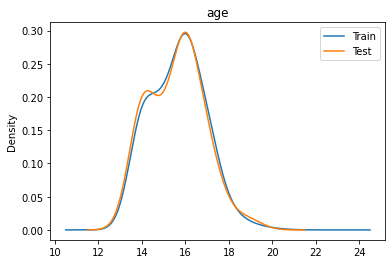

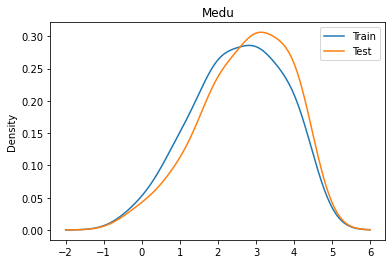

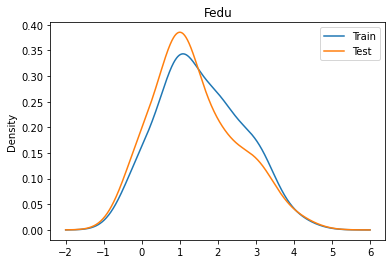

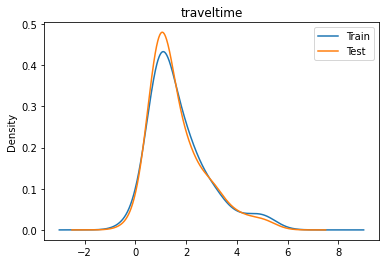

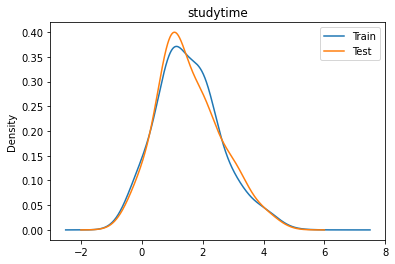

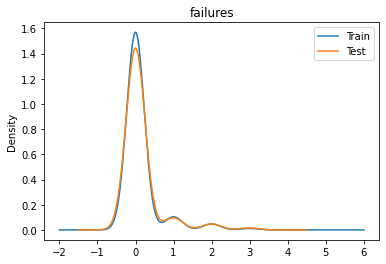

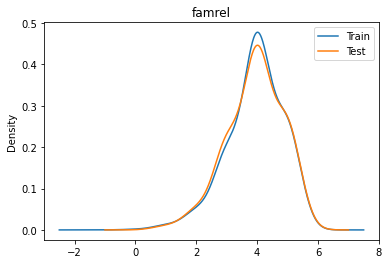

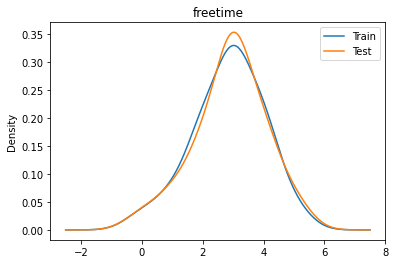

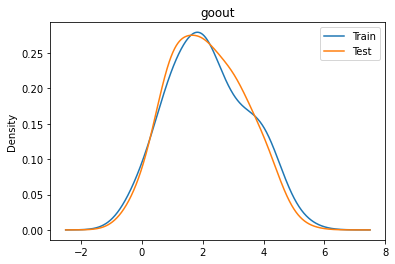

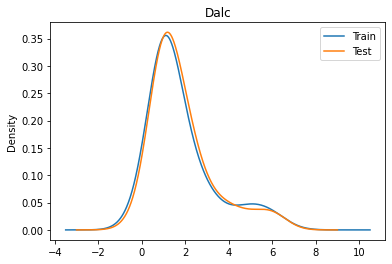

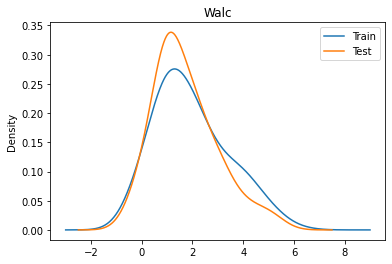

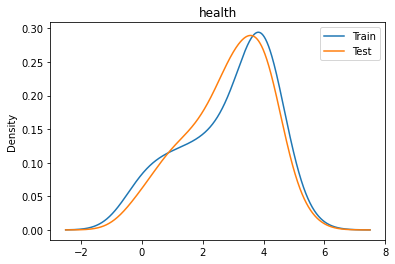

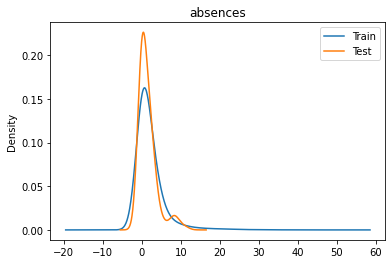

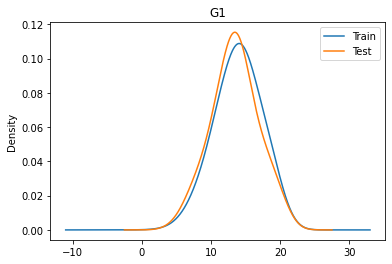

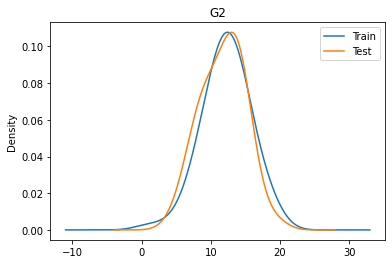

In [ ]:
scale_features = ["age","Medu","Fedu","traveltime","studytime","failures","famrel","freetime","goout","Dalc","Walc","health","absences","G1","G2"]
for fet in scale_features:
    trainFull[fet].plot.kde(bw_method = 0.5)
    testFull[fet].plot.kde(bw_method = 0.5)
    plt.title(fet)
    plt.legend(['Train','Test'])
    plt.show() 



The majority of numeric classes don't display a normal distribution, therefore the features should be normalised rather than standardised. We can also see that the grade is reasonably normally distributed around 9. As we are treating this as a classification task this represents an imbalanced dataset with the categories either side of 9 being less represented. Also the test and train datasets display similar distributions so the train set can be taken to be representative of the test set.

This problem is being treated as a classification problem so originally the majority classes were downsampled using stratified sampling however the disparity in class sizes was too large so there wasn't sufficient data to train a good model. As a result the set will be artificially upsampled using SMOTE. This method creates synthetic instances of minority classes along the lines connecting k nearest neighbours as seen in (N. V. Chawla, K. W. Bowyer, L. O.Hall, W. P. Kegelmeyer, “SMOTE: synthetic minority over-sampling technique,” Journal of artificial intelligence research, 321-357, 2002) This was also perfomed to help with overfitting which was observed during initial testing when class weighting was used to balance the set. The model is also more likely to generalise better if it sees a larger array of examples during training. 

In [ ]:
sm = SMOTENC(random_state=42, categorical_features=[0,1,3,4,5,8,9,10,11,15,16,17,18,19,20,21,22],k_neighbors = 1)
x_res,y_res = sm.fit_resample((trainFull.drop(["Grade"],axis = 1)),trainFull["Grade"])


In [ ]:
trainFull = pd.concat([x_res,y_res],axis=1)

Normalising the data using minmax scaler rather than standard as the data is not all normally distributed

In [ ]:
#Scale the train and test datasets

scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(trainFull[scale_features])

train_normalized = scaler.transform(trainFull[scale_features])
test_normalized = scaler.transform(testFull[scale_features])

trainFull_normalized = trainFull
trainFull_normalized[scale_features] = train_normalized

testFull_normalized = testFull
testFull_normalized[scale_features] = test_normalized


One Hot encode the categorical variables for the simple dense network, drop first column for each as they are collinear. This can cause issues if there is a high degree of crosscorellation between features (ie one can be predicted from the others).

In [ ]:
oneHot_drop = scale_features.copy()
oneHot_drop.append('Grade')
enc = OneHotEncoder(drop = 'first')
enc.fit(trainFull_normalized.drop(oneHot_drop, axis=1))
train_onehot = enc.transform(trainFull_normalized.drop(oneHot_drop, axis=1))
test_onehot = enc.transform(testFull_normalized.drop(scale_features, axis=1))

Create an array of continuous Variables to later concatenate with the one hot encoded categorical ones

In [ ]:

train_num = trainFull_normalized[scale_features]
test_num = testFull_normalized[scale_features]

Concatenate the two arrays to get the input for the first dense model

In [ ]:

train_onehot = train_onehot.toarray()
test_onehot = test_onehot.toarray()

In [ ]:
train_one = np.concatenate((train_num,train_onehot), axis=1)
test_one = np.concatenate((test_num,test_onehot), axis=1)

Split the data into training and validation set for first deep model and standard machine learning

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(train_one,trainFull["Grade"],test_size=0.2, random_state=42)

## MLP neural network

The optimum values for the hyperparmeters and networks structure were found using keras tuner's random search function. This is a hyperparameter optimisation tool that forms part of the keras library. Random search will randomly define hyperparameters within a predefined search space and fit the model accordingly. It will then preserve the best model which can be used to make predictions. The downside of using random search is there is no gaurantee the optimum combiation will be found within the search space and predefined number of trials. By using keras tuner instead of the more popular scikitlearn randomsearchCV the progress made in the search can be saved. This is helpful as the notebook is executed using google colab which has a limited time that a notebook can run. In the event the notebook is disconnected the search can be restarted from the same point. The architectural parameters considered in the search were:<br>
-Number of layers, most problems can be solved by using a single hidden layer, a range of 1-4 layers was searched as increasing the number of layers increases the capacity of the model to learn without the resources required if a single very wide layer was used. The range of 1-4 layers was chosen to limit the model complexity. <br>
-Number of neurons per layer,a range of 32 -128 was chosen as a rule of thumb having twice as many neurons in the hidden layer as the input layer is a good starting point. This range allows for searching in this region as there are 41 inputs. The step size of 16 is chosen as it is common practive to use multiples of 8 as the step size. <br>
-Neuron_decay - this defines whether the layer size will shrink with each consecutive layer, so a neuron decay of 2 means each subsequent hidden layer is half the size of the one before.  <br>
-Dropout rate was also considered, utilising dropout can reduce the liklihood of overfitting in the network a range of 0.1-0.4 was chosen as any higher would greatly change the architecture of the network during training
-Activation Function, the activation function can effect the learning of the model as sigmoid and tanh can cause saturating gradients and slower learning whereas Relu can cause faster learning but can also come at the cost of creating dead neurons if the output is less than 0<br>
-Learning rate, the learning rate governs how aggresively the adam optimiser will converge on local minima. The learning rate is very problem specific so a large range was chosen with log sampling this means every factor of 10 is considered equally.

In [ ]:
def class_build_model(hp):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.Input(shape = 41))

    for i in range(hp.Int("layers", min_value=1, max_value=4, step=1)):
        model.add(tf.keras.layers.Dense(((hp.Int("neurons", min_value=32, max_value=128, step=16))/((hp.Int("neuron_decay", min_value=1, max_value=2, step=1))**i)),
                                        activation=hp.Choice("activation", ["relu", "tanh","sigmoid"])))
        model.add(tf.keras.layers.Dropout(hp.Float("drop", min_value=0.1, max_value=0.4, step = 0.1)))

        
    model.add(tf.keras.layers.Dense(13, activation='softmax'))
    optim= keras.optimizers.Adam(learning_rate=hp.Float("lr", min_value=1e-5, max_value=1e-2, sampling="log"))
    model.compile(optimizer=optim,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return model

In [ ]:
hp = kt.HyperParameters()

In [ ]:
model = class_build_model(hp)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 32)                1344      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 13)                429       
                                                                 
Total params: 1,773
Trainable params: 1,773
Non-trainable params: 0
_________________________________________________________________


Check to see if train and val have same categories

In [ ]:
cats = y_val.unique()
cats2 = y_train.unique()

cats = np.sort(cats)
cats2 = np.sort(cats2)
print(cats)
print(cats2)

[ 5  6  7  8  9 10 11 12 13 14 16 17 18]
[ 5  6  7  8  9 10 11 12 13 14 16 17 18]


label encode the output variables

In [ ]:
label_enc = LabelEncoder()
label_enc.fit(y_train)
y_train_enc = label_enc.transform(y_train)
y_val_enc = label_enc.transform(y_val)

Train the model

In [ ]:
#after first search if disconnected from colab
tuner = kt.RandomSearch(
      class_build_model,
      objective="val_accuracy",
      max_trials=100,
      executions_per_trial=2,
      directory=".//drive//MyDrive//kerastuner",
      overwrite=False,
      project_name="model1",)

INFO:tensorflow:Reloading Oracle from existing project .//drive//MyDrive//kerastuner/model1/oracle.json
INFO:tensorflow:Reloading Tuner from .//drive//MyDrive//kerastuner/model1/tuner0.json


In [ ]:
tuner.search(x_train, y_train_enc,epochs = 30, batch_size = 300,validation_data=(x_val, y_val_enc),callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

INFO:tensorflow:Oracle triggered exit


Retrain the model with the best hyperparameters

In [ ]:
best_model1 = tuner.get_best_hyperparameters()

In [ ]:
model = class_build_model(best_model1[0])

In [ ]:
history = model.fit(x=x_train,y=y_train_enc,epochs = 30, validation_data=(x_val, y_val_enc),callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

Epoch 1/30
3434/3434 [==============================] - 15s 4ms/step - loss: 0.5693 - accuracy: 0.8098 - val_loss: 0.2884 - val_accuracy: 0.9125
Epoch 2/30
3434/3434 [==============================] - 13s 4ms/step - loss: 0.2540 - accuracy: 0.9110 - val_loss: 0.1992 - val_accuracy: 0.9292
Epoch 3/30
3434/3434 [==============================] - 24s 7ms/step - loss: 0.1985 - accuracy: 0.9289 - val_loss: 0.1581 - val_accuracy: 0.9471
Epoch 4/30
3434/3434 [==============================] - 23s 7ms/step - loss: 0.1693 - accuracy: 0.9378 - val_loss: 0.1294 - val_accuracy: 0.9544
Epoch 5/30
3434/3434 [==============================] - 12s 4ms/step - loss: 0.1520 - accuracy: 0.9443 - val_loss: 0.1229 - val_accuracy: 0.9566
Epoch 6/30
3434/3434 [==============================] - 13s 4ms/step - loss: 0.1413 - accuracy: 0.9478 - val_loss: 0.1128 - val_accuracy: 0.9604
Epoch 7/30
3434/3434 [==============================] - 12s 3ms/step - loss: 0.1332 - accuracy: 0.9510 - val_loss: 0.0997 - val_ac

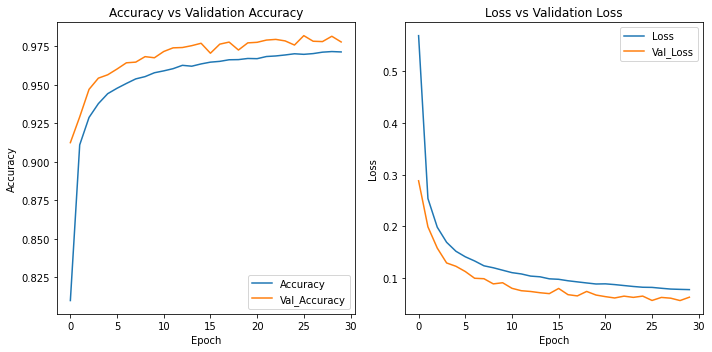

In [ ]:
displayAccuracyLossGraphs(history)

In [ ]:
test_preds = model.predict(test_one)

In [ ]:
test_pred = np.argmax(test_preds, axis=-1)

In [ ]:
print(test_pred)

[4 4 4 4 4 4 4 4 9 4 4 4 4 4 4 6 4 4 6 4 4 4 6 2 3 1 2 3 4 4 4 4 9 3 4 3 4
 4 4 3 4 3 6 4 6 4 6 4 5 4 4 4 5 4 6 4 3 4 6 3 4 5 5 4 4 4 3 4 4 4 3 4 4 4
 5 3 4 4 3 4 5 4 4 4 3 8 3 4 2 4 4 3 8 4 4 4 4 2 4 5 5]


In [ ]:
out = label_enc.inverse_transform(test_pred)
print(out)

[ 9  9  9  9  9  9  9  9 14  9  9  9  9  9  9 11  9  9 11  9  9  9 11  7
  8  6  7  8  9  9  9  9 14  8  9  8  9  9  9  8  9  8 11  9 11  9 11  9
 10  9  9  9 10  9 11  9  8  9 11  8  9 10 10  9  9  9  8  9  9  9  8  9
  9  9 10  8  9  9  8  9 10  9  9  9  8 13  8  9  7  9  9  8 13  9  9  9
  9  7  9 10 10]


In [ ]:
pd.DataFrame(data={"Id" : test_id, "Grade" : out}).to_csv('prediction.csv', index=False)

Generate confusion matrix for first dense model for comparison

In [ ]:
val_preds = model.predict(x_val)
val_pred = np.argmax(val_preds, axis=-1)
val_pred = label_enc.inverse_transform(val_pred)
dense_cm = confusion_matrix(y_val, val_pred)

In [ ]:
print('Model F1 score: {0:0.4f}'. format(f1_score(y_val, val_pred, average = 'macro')))

Model F1 score: 0.9778


## Wide and Deep Architecture

By onehot encoding we recieve a martix with 41 columns, this is large and would mean the wide and deep model would have an excessive number of parameters to train. If an ordinal encoder is used this will have less parameters but using this approach it is likely the model will infer a relationship between the values that isn't there as the encoder assings increasing values based on a number of categories. In order to improve accuracy I embedded the ordinally encoded categorical variables. Consequently using an embeding layer greatly increased the results. I therefore embed the variables to encode the categorical features as a lower dimension vector that better represents the data which can then be concantenated to the normalised continuous variables for use in our neural network. Following categorical embedding a wide and deep architecture was employed this type of architecture has been seen to perform very well as the wide portion of the network can effectively memorise specifics about the training examples whereas the deep portion allows the network to generalise well without the need for excessive feature engineering, as detailed in Wide & Deep Learning for Recommender Systems, Cheng et al, 2016, available at: https://arxiv.org/pdf/1606.07792.pdf.


In [ ]:
def class_wide_and_deep(hp2):
    #Embedding of categorical variables initially
    embeddings = []
    n_emb = hp2.Int("n_embeddings", min_value=1, max_value=3, step=1)

    num_data = keras.layers.Input(shape = (15), name='num_data')
    cat_data= keras.layers.Input(shape = (17),name='cat_data')
    for col in range(16):
      input = cat_data[:,col]
      cat_embedded = keras.layers.Embedding(int(train_cat.max()) + 1 ,n_emb)(input)
      embeddings.append(cat_embedded)

    cat_concatenated = keras.layers.Concatenate()(embeddings)
    #flat_cat = keras.layers.Flatten()(cat_embedded)
    concatenated = keras.layers.Concatenate()([cat_concatenated, num_data])
    out = keras.layers.Flatten()(concatenated)

    #Deep Layers
    out1 = keras.layers.Dense(hp2.Int("n_neurons", min_value=32, max_value=128, step=16),activation=hp2.Choice("activation", ["relu", "tanh","sigmoid"]),kernel_initializer='he_normal')(out)
    for i in range(hp2.Int("n_hidden", min_value=1, max_value=4, step=1)-1):
      out1 = keras.layers.Dense(hp2.Int("n_neurons", min_value=32, max_value=128, step=16),activation=hp2.Choice("activation", ["relu", "tanh","sigmoid"]),kernel_initializer='he_normal')(out1)

    #Wide Layer
    out2 = keras.layers.Dense(hp2.Int("n_neurons2", min_value=8, max_value=32, step=8),activation=hp2.Choice("activation", ["relu", "tanh","sigmoid"]),kernel_initializer='he_normal')(out)

    #Concat output from deep and wide sections and pass through final dense layer
    concatenated2 = keras.layers.Concatenate()([out1, out2])
    output = tf.keras.layers.Dense(13, activation='softmax')(concatenated2)
    optim= keras.optimizers.Adam(learning_rate=hp2.Float("lr", min_value=1e-5, max_value=1e-2, sampling="log"))
    model = keras.Model(inputs=[num_data,cat_data], outputs=[output])
    model.compile(optimizer=optim,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

    return model

In [ ]:
hp2 = kt.HyperParameters()

In [ ]:
#ordinally encode all categorical data
ordinal_cat = OrdinalEncoder()
ordinal_cat.fit(trainFull_normalized.drop(oneHot_drop, axis=1))
train_cat = ordinal_cat.transform(trainFull_normalized.drop(oneHot_drop,axis =1))
test_cat = ordinal_cat.transform(testFull_normalized.drop(scale_features,axis =1))


In [ ]:
num_train, num_val,cat_train,cat_val, y_train, y_val = train_test_split(train_num,train_cat, trainFull["Grade"],test_size=0.2, random_state=42)

y_train_enc = label_enc.transform(y_train)
y_val_enc = label_enc.transform(y_val)

In [ ]:
#after first search if disconnected from colab
tuner = kt.RandomSearch(
      class_wide_and_deep,
      objective="val_accuracy",
      max_trials=50,
      executions_per_trial=2,
      directory=".//drive//MyDrive//kerastuner",
      overwrite=False,
      project_name="modeltest",)

INFO:tensorflow:Reloading Oracle from existing project .//drive//MyDrive//kerastuner/modeltest/oracle.json
INFO:tensorflow:Reloading Tuner from .//drive//MyDrive//kerastuner/modeltest/tuner0.json


In [ ]:
tuner.search([num_train,cat_train], y_train_enc,epochs = 30, batch_size = 300,validation_data=([num_val,cat_val], y_val_enc),callbacks =[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)] )

INFO:tensorflow:Oracle triggered exit


In [ ]:
best_model2 = tuner.get_best_hyperparameters()

In [ ]:
model2 = class_wide_and_deep(best_model2[0])

In [ ]:
history2 = model2.fit(x=[num_train,cat_train],y=y_train_enc,epochs = 50, validation_data=([num_val,cat_val], y_val_enc),callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

Epoch 1/50
3434/3434 [==============================] - 45s 12ms/step - loss: 0.2583 - accuracy: 0.9076 - val_loss: 0.1432 - val_accuracy: 0.9431
Epoch 2/50
3434/3434 [==============================] - 42s 12ms/step - loss: 0.1199 - accuracy: 0.9566 - val_loss: 0.0868 - val_accuracy: 0.9691
Epoch 3/50
3434/3434 [==============================] - 41s 12ms/step - loss: 0.0922 - accuracy: 0.9665 - val_loss: 0.0750 - val_accuracy: 0.9744
Epoch 4/50
3434/3434 [==============================] - 41s 12ms/step - loss: 0.0785 - accuracy: 0.9715 - val_loss: 0.0584 - val_accuracy: 0.9803
Epoch 5/50
3434/3434 [==============================] - 41s 12ms/step - loss: 0.0694 - accuracy: 0.9753 - val_loss: 0.0631 - val_accuracy: 0.9771
Epoch 6/50
3434/3434 [==============================] - 41s 12ms/step - loss: 0.0624 - accuracy: 0.9781 - val_loss: 0.0557 - val_accuracy: 0.9814
Epoch 7/50
3434/3434 [==============================] - 41s 12ms/step - loss: 0.0563 - accuracy: 0.9802 - val_loss: 0.0597 -

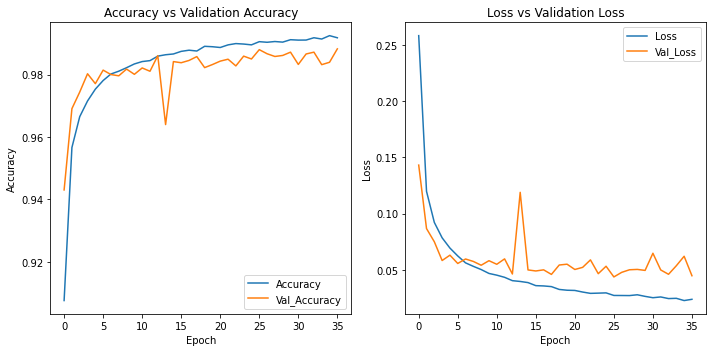

In [ ]:
displayAccuracyLossGraphs(history2)

In [ ]:
prediction2 = model2.predict([test_num,test_cat])
predict_classes2=np.argmax(prediction2,axis=1)


In [ ]:
print(predict_classes2)
output2 = label_enc.inverse_transform(predict_classes2)
print(output2)

[4 4 4 4 4 4 4 3 9 4 4 4 4 4 4 6 4 4 6 4 4 5 6 3 3 1 2 3 4 4 4 4 8 3 4 3 4
 4 4 3 4 3 6 4 6 4 6 4 5 4 4 4 5 4 6 4 3 4 6 2 4 5 4 4 4 4 3 4 4 4 3 4 4 4
 5 3 4 4 4 4 4 4 4 4 3 8 3 4 1 4 4 3 8 4 4 4 4 2 4 5 5]
[ 9  9  9  9  9  9  9  8 14  9  9  9  9  9  9 11  9  9 11  9  9 10 11  8
  8  6  7  8  9  9  9  9 13  8  9  8  9  9  9  8  9  8 11  9 11  9 11  9
 10  9  9  9 10  9 11  9  8  9 11  7  9 10  9  9  9  9  8  9  9  9  8  9
  9  9 10  8  9  9  9  9  9  9  9  9  8 13  8  9  6  9  9  8 13  9  9  9
  9  7  9 10 10]


In [ ]:
pd.DataFrame(data={"Id" : test_id, "Grade" : output2}).to_csv('prediction2.csv', index=False)

Generate confusion matrix for wide and deep network

In [ ]:
val_preds2 = model2.predict([num_val,cat_val])
val_pred2 = np.argmax(val_preds2, axis=-1)
val_pred2 = label_enc.inverse_transform(val_pred2)
w_and_d_cm = confusion_matrix(y_val, val_pred2)

In [ ]:
print('Model F1 score: {0:0.4f}'. format(f1_score(y_val, val_pred2, average = 'macro')))

Model F1 score: 0.9880


## Evaluate the performance by Analysing the Confusion Matrices for the 2 models

# Dense Model

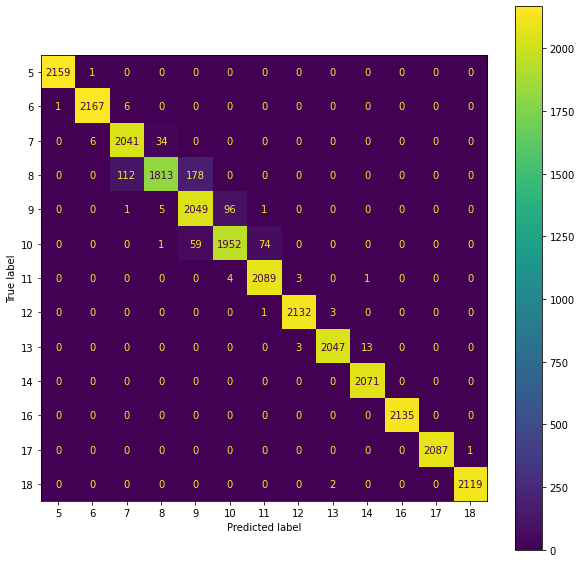

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=dense_cm,display_labels = cats)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.show()

# Wide and Deep Model

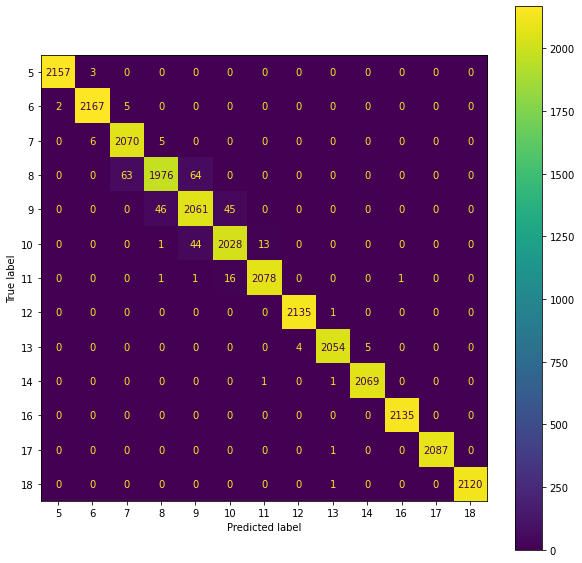

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=w_and_d_cm,display_labels = cats)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.show()

 The performance of the two models was very similar with each achieving high levels of overall accuracy. It is noted however that both models had the highest number of missclassifications in the region of 7-10 with lots of grades being missclassified in this area. This indicates that there is likely a lot of overlap in the data across these grades making the separation difficult. One way to possibly improve performance would have been to use feature engineering to possibly make these classes more seperable. The results found on the validation set here were also consistent with what was observed on the test set for the two deep networks, when uploaded to Kaggle the dense model had an F1 score of 0.94 and the wide and deep achieved the best score of 0.96.

## Upload Results to Kaggle

Standard Model

Dense Model 1

In [ ]:
uploadDataToKaggle(test_id, out, "task2", upload=False)

Dense Model 2

In [ ]:
uploadDataToKaggle(test_id, output2, "task2", upload=False)

Export contents of notebook to html to then be saved as PDF

In [9]:
!jupyter-nbconvert --ExecutePreprocessor.enabled=False --to html /content/Assignment_2_Task2.ipynb

[NbConvertApp] Converting notebook /content/Assignment_2_Task2.ipynb to html
[NbConvertApp] Writing 911831 bytes to /content/Assignment_2_Task2.html
